## Imports

In [3]:
% matplotlib inline
import warnings
from collections import Counter, OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import pyarrow as pa   
import pyarrow.parquet as pq
from fastparquet import ParquetFile 
from scipy import sparse
from scipy.spatial.distance import pdist, squareform

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import seaborn as sns

# spacy, textblob and nltk for language processing
from textblob import TextBlob, Word

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.externals import joblib

import lightgbm as lgb

import json
from time import clock, time

In [4]:
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

## News article classification

### Read BBC articles

In [5]:
path = Path('data', 'bbc')
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    topic = file.parts[-2]
    article = file.read_text(encoding='latin1').split('\n')
    heading = article[0].strip()
    body = ' '.join([l.strip() for l in article[1:]])
    doc_list.append([topic, heading, body])

In [6]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'body'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
topic      2225 non-null object
heading    2225 non-null object
body       2225 non-null object
dtypes: object(3)
memory usage: 52.2+ KB


### Create stratified train-test split

In [7]:
y = pd.factorize(docs.topic)[0]
X = docs.body
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

### Vectorize text data

In [8]:
vectorizer = CountVectorizer()
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

In [9]:
X_train_dtm.shape, X_test_dtm.shape

((1668, 25919), (557, 25919))

### Train Multi-class Naive Bayes model

In [10]:
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

### Evaluate Results

#### Accuracy

In [12]:
accuracy_score(y_test, y_pred_class)

0.9766606822262118

#### Confusion matrix

In [13]:
pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred_class))

,0,1,2,3,4
0,98,0,0,2,0
1,0,128,0,0,0
2,0,0,102,2,0
3,2,0,5,121,0
4,0,0,1,1,95


## Twitter Sentiment

- 0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive); training data has no neutral tweets
- 1 - the id of the tweet (2087)
- 2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- 3 - the query (lyx). If there is no query, then this value is NO_QUERY. (only test data uses query)
- 4 - the user that tweeted (robotickilldozr)
- 5 - the text of the tweet (Lyx is cool)

### Read train/test data

In [12]:
names = ['polarity', 'id', 'date', 'query', 'user', 'text']
train = (pd.read_csv('data/sentiment140/train.csv',
                     low_memory=False,
                     encoding='latin1',
                     header=None,
                     names=names,
                     parse_dates=['date'])
         .drop(['id', 'query'], axis=1)
         .drop_duplicates(subset=['polarity', 'text']))

train = train[train.text.str.len()<=140]
train.polarity = (train.polarity>0).astype(int)

In [13]:
train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1566668 entries, 0 to 1599999
Data columns (total 4 columns):
polarity    1566668 non-null int64
date        1566668 non-null datetime64[ns]
user        1566668 non-null object
text        1566668 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 59.8+ MB


In [14]:
train.to_parquet('data/sentiment140/train.parquet')

In [57]:
test = (pd.read_csv('data/sentiment140/test.csv',
                    low_memory=False,
                    encoding='latin1',
                    header=None,
                    names=names,
                    parse_dates=['date'])
        .drop(['id', 'query'], axis=1)
        .drop_duplicates(subset=['polarity', 'text']))
test = test[(test.text.str.len()<=140) & (test.polarity.isin([0,4]))]

In [58]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 0 to 497
Data columns (total 4 columns):
polarity    354 non-null int64
date        354 non-null datetime64[ns]
user        354 non-null object
text        354 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 13.8+ KB


In [59]:
test.to_parquet('data/sentiment140/test.parquet')

In [54]:
train = pd.read_parquet('data/sentiment140/train.parquet')
test = pd.read_parquet('data/sentiment140/test.parquet')

### Explore data

In [60]:
train.head()

,polarity,date,user,text
0,0,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
2,0,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,0,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."


In [62]:
train.polarity = (train.polarity>0).astype(int)
train.polarity.value_counts()

1    784335
0    782333
Name: polarity, dtype: int64

In [63]:
test.polarity = (test.polarity>0).astype(int)
test.polarity.value_counts()

1    180
0    174
Name: polarity, dtype: int64

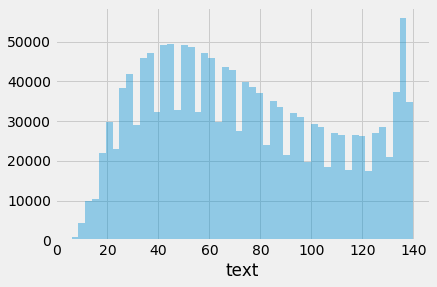

In [64]:
sns.distplot(train.text.str.len(), kde=False);

In [65]:
train.date.describe()

count                 1566668
unique                 765666
top       2009-06-15 12:53:14
freq                       20
first     2009-04-06 22:19:45
last      2009-06-25 10:28:31
Name: date, dtype: object

In [66]:
train.user.nunique()

650606

In [53]:
train.user.value_counts().head(10)

lost_dog           549
webwoke            341
SallytheShizzle    276
VioletsCRUK        275
mcraddictal        274
tsarnick           247
what_bugs_u        246
Karen230683        237
DarkPiano          232
SongoftheOss       226
Name: user, dtype: int64

### Create text vectorizer

In [68]:
vectorizer = CountVectorizer(min_df=.001, max_df=.8, stop_words='english')
train_dtm = vectorizer.fit_transform(train.text)

In [69]:
train_dtm

<1566668x934 sparse matrix of type '<class 'numpy.int64'>'
	with 6332930 stored elements in Compressed Sparse Row format>

In [70]:
test_dtm = vectorizer.transform(test.text)

### Train Naive Bayes Classifier

In [89]:
nb = MultinomialNB()
nb.fit(train_dtm, train.polarity)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Predict Test Polarity

In [ ]:
predicted_polarity = nb.predict(test_dtm)

### Evaluate Results

In [90]:
accuracy_score(test.polarity, y_pred_class)

0.7768361581920904

### TextBlob for Sentiment Analysis

In [243]:
sample_positive = train.text.loc[256332]
print(sample_positive)
parsed_positive = TextBlob(sample_positive)
parsed_positive.polarity

Ok its cake and ice cream time! Ha! See what I'm talking about! The temptation is there! 


1.0

In [244]:
sample_negative = train.text.loc[636079]
print(sample_negative)
parsed_negative = TextBlob(sample_negative)
parsed_negative.polarity

 i hate this place


-0.8

In [26]:
def estimate_polarity(text):
    return TextBlob(text).sentiment.polarity

In [245]:
train[['text']].sample(10).assign(sentiment=lambda x: x.text.apply(estimate_polarity)).sort_values('sentiment')

,text,sentiment
531747,@Adeline604 Kill it for the cat.. ?,0.000000
831701,Frazzi is on her way here and we'll edit our P...,0.000000
946557,in bed. i think i may be gettin another bestie!!,0.000000
529010,http://twitpic.com/7jzy3 - my gingerkits. wobb...,0.000000
407855,come on... drop by 37 53. sulumitsretsambewno...,0.000000
215660,@kimbosliceey Huntington Beach. Sat/Sun. I can...,0.000000
1378600,"@BengoliBeauty I'm sorry, Be strong now when H...",0.368522
838296,@jp1983 it was fun!,0.375000
1034526,"my good golly it was hot today at the barn, I ...",0.475000
1349111,more Ta-Ta Tailgate plans in the works!!!! Det...,1.000000


### Compare with TextBlob Polarity Score

In [73]:
test['sentiment'] = test.text.apply(estimate_polarity)

In [112]:
accuracy_score(test.polarity, (test.sentiment>0).astype(int))

0.7429378531073446

#### ROC AUC Scores

In [86]:
roc_auc_score(y_true=test.polarity, y_score=test.sentiment)

0.8254948914431672

In [87]:
roc_auc_score(y_true=test.polarity, y_score=nb.predict_proba(test_dtm)[:, 1])

0.848595146871009

In [99]:
fpr_tb, tpr_tb, _ = roc_curve(y_true=test.polarity, y_score=test.sentiment)
roc_tb = pd.Series(tpr_tb, index=fpr_tb)
fpr_nb, tpr_nb, _ = roc_curve(y_true=test.polarity, y_score=nb.predict_proba(test_dtm)[:, 1])
roc_nb = pd.Series(tpr_nb, index=fpr_nb)

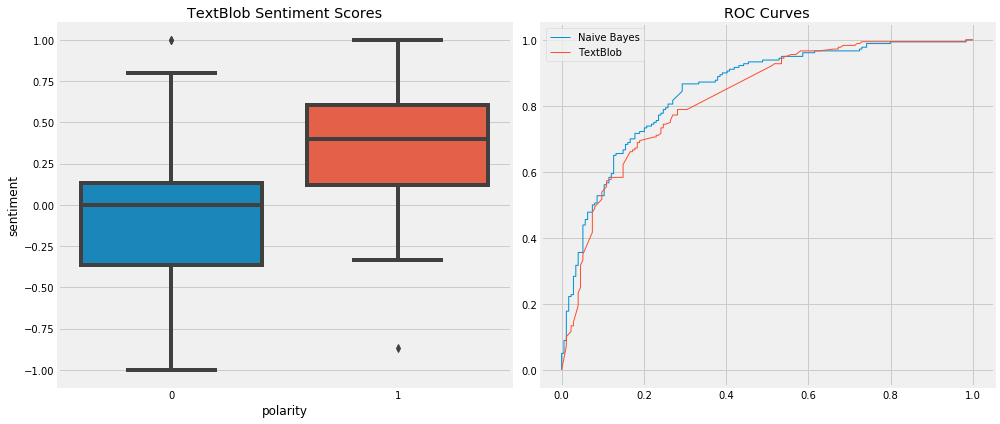

In [111]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.boxplot(x='polarity', y='sentiment', data=test, ax=axes[0])
axes[0].set_title('TextBlob Sentiment Scores')
roc_nb.plot(ax=axes[1], label='Naive Bayes', legend=True, lw=1, title='ROC Curves')
roc_tb.plot(ax=axes[1], label='TextBlob', legend=True, lw=1)
fig.tight_layout();

## Yelp Challenge: business reviews dataset

### Set up data directories

In [5]:
yelp_dir = Path('data', 'yelp')
parquet_dir = yelp_dir / 'parquet'
if not parquet_dir.exists():
    parquet_dir.mkdir(exist_ok=True)
text_features_dir = yelp_dir / 'text_features'
if not text_features_dir.exists():
    text_features_dir.mkdir(exist_ok=True)    

### Parse json and store as parquet files

In [ ]:
# move the review and user files into a new 'json' folder
# we will only use yelp_academic_dataset_{review|user}.json

for file in ['review', 'user']:
    print(file)
    json_file = yelp_dir / 'json' / f'yelp_academic_dataset_{file}.json'
    parquet_file = parquet_dir / f'{file}.parquet'

    data = json_file.read_text(encoding='utf-8')
    json_data = '[' + ','.join([l.strip()
                                for l in data.split('\n') if l.strip()]) + ']\n'
    data = json.loads(json_data)
    df = json_normalize(data)
    if file == 'review':
        df.date = pd.to_datetime(df.date)
        latest = df.date.max()
        df['year'] = df.date.dt.year
        df['month'] = df.date.dt.month
        df = df.drop(['date', 'business_id', 'review_id'], axis=1)
    if file == 'user':
        df.yelping_since = pd.to_datetime(df.yelping_since)
        df = (df.assign(member_yrs=lambda x: (latest - x.yelping_since)
                        .dt.days.div(365).astype(int))
              .drop(['elite', 'friends', 'name', 'yelping_since'], axis=1))
    df.dropna(how='all', axis=1).to_parquet(parquet_file, compression='gzip')
    try:
        pd.read_parquet(parquet_file, engine='pyarrow')
    except Exception as e:
        print(e)
        # at the time of writing, pyarrow had a bug re large text columns
        # https://issues.apache.org/jira/browse/ARROW-3762
        pd.read_parquet(parquet_file, engine='fastparquet')

In [ ]:
user = pd.read_parquet(parquet_dir / 'user.parquet')
user.info(null_counts=True)

In [ ]:
user.head()

In [ ]:
review = pd.read_parquet(parquet_dir / 'review.parquet', engine='fastparquet')
review.info(null_counts=True)

### Merge review and user files

In [ ]:
combined = (review
            .merge(user, on='user_id', how='left', suffixes=['', '_user'])
            .drop('user_id', axis=1))
combined = combined[combined.stars > 0]
combined.info(null_counts=True)

In [ ]:
combined.to_parquet(parquet_dir / 'combined.parquet', compression='gzip')

In [6]:
combined = pd.read_parquet(parquet_dir / 'combined.parquet', engine='fastparquet')

### Explore data

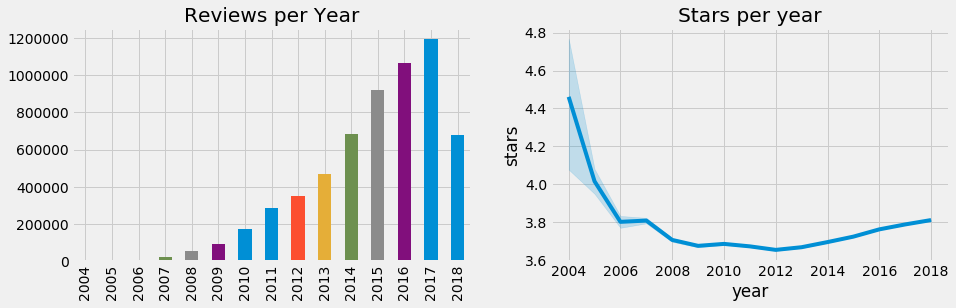

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
combined.year.value_counts().sort_index().plot.bar(title='Reviews per Year', ax=axes[0]);
sns.lineplot(x='year', y='stars', data=combined, ax=axes[1])
axes[1].set_title('Stars per year');

In [8]:
combined.member_yrs.value_counts().sort_index()

0     159440
1     336847
2     607776
3     747215
4     753483
5     789312
6     767460
7     750720
8     484111
9     326262
10    170026
11     78357
12     21801
13      4185
Name: member_yrs, dtype: int64

In [9]:
combined.stars.value_counts(normalize=True).sort_index().mul(100)

1    14.309483
2     8.134291
3    11.225722
4    22.277107
5    44.053397
Name: stars, dtype: float64

### Create train-test split

In [ ]:
train = combined[combined.year < 2018]
test = combined[combined.year == 2018]

In [ ]:
train.to_parquet(parquet_dir / 'train.parquet', compression='gzip')
test.to_parquet(parquet_dir / 'test.parquet', compression='gzip')

In [10]:
train = pd.read_parquet(parquet_dir / 'train.parquet', engine='fastparquet')
test = pd.read_parquet(parquet_dir / 'test.parquet', engine='fastparquet')

### Benchmark Accuracy

In [16]:
test['predicted'] = train.stars.mode().iloc[0]

In [18]:
accuracy_score(test.stars, test.predicted)

0.5196950594793454

### Create Yelp review document-term matrix

In [ ]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=10000)
train_dtm = vectorizer.fit_transform(train.text)
train_dtm

In [ ]:
sparse.save_npz(text_features_dir / 'train_dtm', train_dtm)

In [255]:
train_dtm = sparse.load_npz(text_features_dir / 'train_dtm.npz')

In [ ]:
test_dtm = vectorizer.transform(test.text)
sparse.save_npz(text_features_dir / 'test_dtm', test_dtm)

In [22]:
test_dtm = sparse.load_npz(text_features_dir / 'test_dtm.npz')

### Train Multiclass Naive Bayes

In [257]:
nb = MultinomialNB()
nb.fit(train_dtm,train.stars)
predicted_stars = nb.predict(test_dtm)

### Evaluate results

In [258]:
accuracy_score(test.stars, predicted_stars)

0.6465164206691094

In [261]:
stars = index=list(range(1,6))
pd.DataFrame(confusion_matrix(test.stars, predicted_stars), 
             columns=stars,
             index=stars)

,1,2,3,4,5
1,81894,20469,3958,1688,2108
2,14103,17228,10539,2651,1634
3,6814,10150,23281,13867,3840
4,4256,3256,13336,64966,25310
5,15812,2004,3756,79891,250567



### Combine non-text features with the document-term matrix

The Vectorizers produce scipy.sparse matrices. To combine the vectorized text data with other features, we need to first convert these to sparse matrices as well; many sklearn algorithm can handle these. Converting the sparse matrix to a dense numpy array risks memory overflow.

#### One-hot-encoding 

In [284]:
df = pd.concat([train.drop(['text', 'stars'], axis=1).assign(source='train'),
                test.drop(['text', 'stars'], axis=1).assign(source='test')])

In [286]:
uniques = df.nunique()
binned = pd.concat([(df.loc[:, uniques[uniques > 20].index]
                     .apply(pd.qcut, q=10, labels=False, duplicates='drop')),
                    df.loc[:, uniques[uniques <= 20].index]], axis=1)
binned.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5996995 entries, 0 to 5996995
Data columns (total 24 columns):
cool                  5996995 non-null int64
funny                 5996995 non-null int64
useful                5996995 non-null int64
average_stars         5996995 non-null int64
compliment_cool       5996995 non-null int64
compliment_cute       5996995 non-null int64
compliment_funny      5996995 non-null int64
compliment_hot        5996995 non-null int64
compliment_list       5996995 non-null int64
compliment_more       5996995 non-null int64
compliment_note       5996995 non-null int64
compliment_photos     5996995 non-null int64
compliment_plain      5996995 non-null int64
compliment_profile    5996995 non-null int64
compliment_writer     5996995 non-null int64
cool_user             5996995 non-null int64
fans                  5996995 non-null int64
funny_user            5996995 non-null int64
review_count          5996995 non-null int64
useful_user           5996995 no

In [287]:
dummies = pd.get_dummies(binned,columns=binned.columns[:-1], drop_first=True)
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5996995 entries, 0 to 5996995
Columns: 109 entries, source to member_yrs_13
dtypes: object(1), uint8(108)
memory usage: 709.2+ MB


In [288]:
train_dummies = dummies[dummies.source=='train'].drop('source', axis=1)
train_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5319617 entries, 0 to 5996992
Columns: 108 entries, cool_1 to member_yrs_13
dtypes: uint8(108)
memory usage: 588.5 MB


#### Train set

In [289]:
# Cast other feature columns to float and convert to a sparse matrix.
train_numeric = sparse.csr_matrix(train_dummies.astype(np.int8))
train_numeric.shape

(5319617, 108)

In [290]:
# Combine sparse matrices.
train_dtm_numeric = sparse.hstack((train_dtm, train_numeric))
train_dtm_numeric.shape

(5319617, 10108)

In [291]:
sparse.save_npz(text_features_dir / 'train_dtm_numeric', train_dtm_numeric)

#### Repeat for test set

In [292]:
test_dummies = dummies[dummies.source=='test'].drop('source', axis=1)
test_numeric = sparse.csr_matrix(test_dummies.astype(np.int8))
test_dtm_numeric = sparse.hstack((test_dtm, test_numeric))
test_dtm_numeric.shape

(677378, 10108)

In [293]:
sparse.save_npz(text_features_dir / 'test_dtm_numeric', test_dtm_numeric)

In [4]:
train_dtm_numeric = sparse.load_npz(text_features_dir / 'train_dtm_numeric.npz')
test_dtm_numeric = sparse.load_npz(text_features_dir / 'test_dtm_numeric.npz')

### Logistic Regression

In [294]:
logreg = LogisticRegression(C=1e9)

#### Text features only

In [ ]:
logreg.fit(X=train_dtm, y=train.stars)
y_pred_class = logreg.predict(test_dtm)

In [ ]:
joblib.dump(logreg, 'train_dtm.joblib') 

In [21]:
logreg = joblib.load('log_reg_multi/train_dtm.joblib')

In [23]:
y_pred_class = logreg.predict(test_dtm)

##### Evaluate Results

In [24]:
print(accuracy_score(test.stars, y_pred_class))

0.7360498864740219


#### Combined Features

##### One-vs-all Logistic Regression

In [295]:
# Use logistic regression with all features.
logreg.fit(train_dtm_numeric.astype(float), train.stars)
y_pred_class = logreg.predict(test_dtm_numeric.astype(float))

In [296]:
joblib.dump(logreg, 'train_dtm_numeric.joblib') 

['train_dtm_numeric.joblib']

In [297]:
accuracy_score(test.stars, y_pred_class)

0.7444292551573862


##### Multinomial Logistic Regression

In [299]:
multi_logreg = LogisticRegression(C=1e9, multi_class='multinomial', solver='lbfgs')
multi_logreg.fit(train_dtm_numeric.astype(float), train.stars)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [300]:
joblib.dump(multi_logreg, 'train_dtm_numeric_multi.joblib')

['train_dtm_numeric_multi.joblib']

In [301]:
y_pred_class = multi_logreg.predict(test_dtm_numeric.astype(float))

In [302]:
accuracy_score(test.stars, y_pred_class)

0.7464488070176475

In [304]:
for solver in ['newton-cg', 'sag', 'saga']:
    start = time()
    multi_logreg = LogisticRegression(C=1e9, multi_class='multinomial', solver=solver)
    multi_logreg.fit(train_dtm_numeric.astype(float), train.stars)
    joblib.dump(multi_logreg, f'train_dtm_numeric_multi_{solver}.joblib')
    y_pred_class = multi_logreg.predict(test_dtm_numeric.astype(float))
    print(f'{solver}: {time()-start:.2f}s | {accuracy_score(test.stars, y_pred_class):.2%}', flush=True)

newton-cg: 35082.35s | 75.14%
sag: 949.32s | 74.46%
saga: 1048.73s | 74.29%


In [ ]:
for C in [1e7, 1e6, 1e5, 1e4, 1e3, 1e2, 1e1, 1, 0.1,0]:
    start = time()
    multi_logreg = LogisticRegression(C=C, multi_class='multinomial', solver='lbfgs')
    multi_logreg.fit(train_dtm_numeric.astype(float), train.stars)
    joblib.dump(multi_logreg, f'train_dtm_numeric_multi_{int(C*10):d}.joblib')
    y_pred_class = multi_logreg.predict(test_dtm_numeric.astype(float))
    print(f'{C}: {time()-start:.2f}s | {accuracy_score(test.stars, y_pred_class):.2%}', flush=True)

### Gradient Boosting

In [31]:
lgb_train = lgb.Dataset(data=train_dtm_numeric.tocsr().astype(np.float32), 
                        label=train.stars.sub(1), 
                        categorical_feature=list(range(train_dtm_numeric.shape[1])))

In [32]:
lgb_test = lgb.Dataset(data=test_dtm_numeric.tocsr().astype(np.float32), 
                       label=test.stars.sub(1), 
                       reference=lgb_train)

In [33]:
param = {'objective':'multiclass', 'num_class': 5}

In [ ]:
booster = lgb.train(params=param, 
                    train_set=lgb_train, 
                    num_boost_round=500, 
                    early_stopping_rounds=20,
                    valid_sets=[lgb_train, lgb_test])

In [35]:
booster.save_model(str(text_features_dir / 'lgb_model.txt'))

In [36]:
y_pred_class = booster.predict(test_dtm_numeric.astype(float))

In [44]:
accuracy_score(test.stars, y_pred_class.argmax(1) + 1)

0.738665855696524

In [ ]:
y_pred_class_class_classd_classed_classred

In [50]:
fi = booster.feature_importance(importance_type='gain')
pd.Series(fi).div(fi.sum()).sort_values(ascending=False).head()

10016    0.093552
3847     0.037409
9888     0.029934
3666     0.028357
10015    0.027905
dtype: float64

### Naive Bayes

In [46]:
nb = MultinomialNB()
nb.fit(train_dtm_numeric,train.stars)
predicted_stars = nb.predict(test_dtm_numeric)
accuracy_score(test.stars, predicted_stars)

0.6689115973651344

## Textblob for Sentiment Analysis

In [ ]:
sample_review = combined.text.sample(1).iloc[0]
print(sample_review)

In [ ]:
# Polarity ranges from -1 (most negative) to 1 (most positive).
TextBlob(sample_review).sentiment.polarity

In [5]:
# Define a function that accepts text and returns the polarity.
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [6]:
combined['sentiment'] = combined.text.apply(detect_sentiment)

In [16]:
combined.to_parquet(parquet_dir / 'combined_tb.parquet', compression='gzip')

In [ ]:
sample_reviews = combined[['stars', 'text']].sample(100000)

In [ ]:
# Create a new DataFrame column for sentiment (Warning: SLOW!).
sample_reviews['sentiment'] = sample_reviews.text.apply(detect_sentiment)

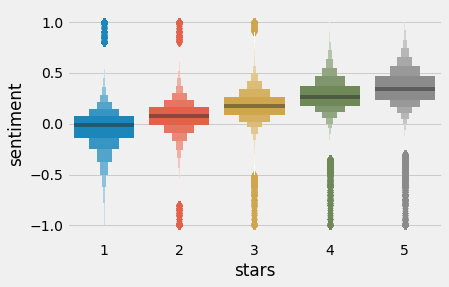

In [8]:
# Box plot of sentiment grouped by stars
sns.boxenplot(x='stars', y='sentiment', data=combined);

In [11]:
# Widen the column display.
pd.set_option('max_colwidth', 500)

In [12]:
# Reviews with most negative sentiment
combined[combined.sentiment == -1].text.head()

955                                                              Giving a star cause I have too. Sat for 15 min and wasn't even acknowledged. I told the manager and it seemed like he didn't care. I got out of there. Horrible customer service.
983                                                                                                          This was the worst Smoothie i have ever had....runny, no flavor and overpriced for what you get... Don't bother...Save your money!!!!
1588    Came for dinner and so unbelievably DISAPPOINTED!! Ordered Salmon which was jerky not a filet. Management deemed it to be edible and did nothing to rectify the situation. Miserable experience and would never recommend this restaurant!
2167                                                                                                                                               Apples support is horrible, eff this place. Honestly WORST customer experiences when I go there
2772                        

In [13]:
# Negative sentiment in a 5-star review
combined[(combined.stars == 5) & (combined.sentiment < -0.3)].head(1)

,cool,funny,stars,text,useful,year,month,average_stars,compliment_cool,compliment_cute,...,compliment_plain,compliment_profile,compliment_writer,cool_user,fans,funny_user,review_count,useful_user,member_yrs,sentiment
106,0,0,5,"I'm not good at explaining how I want my hair since I always change it up every time I see her, but she is always on point! My hairdresser for the past 3 years and I have never left disappointed!! Xoxo",0,2016,8,3.61,0,0,...,0,0,0,0,0,0,16,6,2,-0.421875


In [15]:
# Positive sentiment in a 1-star review
combined.loc[(combined.stars == 1) & (combined.sentiment > 0.5), 'text'].head(1)

1676    I went here today for a nice meal. The waiter was great. I asked for my dueling lobster tails to be served without shrimp. The meal was brought out with the shrimp in it. Even though the manager asked me what I needed and apologized, there was no offer to take money off of my meal for the mistake. In addition, I was charged ninety nine cents because of my request. This is not how customers should be treated.
Name: text, dtype: object

In [ ]:
# Reset the column display width.
pd.reset_option('max_colwidth')